In [ ]:
# Interpolation and calculation of Drought Indices using precipitation data, hotspots and trends

In [ ]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, ExpSineSquared, ConstantKernel, RBF, Matern, RationalQuadratic

In [ ]:
import time as time2
import os
# Interpolate spatially using GaussianProcessRegressor (modified Kriging)
# create a grid of latitude and longitude coordinates
lat_grid = np.linspace(55.3376, 69.1763, 100) 
lon_grid = np.linspace(11, 24.113, 100)
nx = len(lon_grid)
ny = len(lat_grid)
times=df_all_mon.ref.unique()
#datesout=pd.to_datetime(times)
dataout=np.zeros((len(times),ny,nx))
#dataout=np.load('dataout_16000.npy')
out_rsquared=[]
in_rsquared=[]

t=0

merged_df=pd.merge(df_stations[['id', 'latitude', 'longitude']], df_all_mon, left_on='id', right_on='station_id')
merged_df=merged_df.sort_values('ref', ascending=True)
start = time2.time()
for n in range(len(times)):
    time=times[n]
    temp_subset = merged_df[merged_df.ref==time]
    # Split data into testing and training sets
    merged_train = temp_subset[['latitude','longitude']]
    coords_train, coords_test, value_train, value_test = train_test_split(merged_train, temp_subset['value'], test_size = 0.20, random_state = 42)
    coords_train_wgs = [np.array(xy) for xy in zip(coords_train.longitude.values, coords_train.latitude.values)]
    coords_test_wgs = [np.array(xy) for xy in zip(coords_test.longitude.values, coords_test.latitude.values)]
    XX_sk_krig, YY_sk_krig = np.mgrid[lon_grid.min():lon_grid.max():100j, lat_grid.min():lat_grid.max():100j]
    # Create 2-D array of the coordinates (paired) of each cell in the mesh grid
    positions_sk_krig = np.vstack([XX_sk_krig.ravel(), YY_sk_krig.ravel()]).T
    kernel2= RationalQuadratic()
    kernel= RBF()

    # Define the hyperparameters
    length_scale = 0.1
    alpha = 0.1

    try:
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3)
        # Fit kernel density estimator to coordinates and values
        gp.fit(coords_train_wgs, value_train)
    except:
        gp = GaussianProcessRegressor(kernel=kernel2, n_restarts_optimizer=3)
        # Fit kernel density estimator to coordinates and values
        gp.fit(coords_train_wgs, value_train)
        print('error')
    # Evaluate the model on coordinate pairs
    Z_sk_krig, std_prediction = gp.predict(positions_sk_krig, return_std=True)
    # Reshape the data to fit mesh grid
    interp_temps = Z_sk_krig.reshape(XX_sk_krig.shape)
    # Generate in-sample R^2
    in_r_squared_sk_krig = gp.score(coords_train_wgs, value_train)
    print("Scikit-Learn Kriging in-sample r-squared: {}".format(round(in_r_squared_sk_krig, 2)))
    # Generate out-of-sample R^2
    out_r_squared_sk_krig = gp.score(coords_test_wgs, value_test)
    print("Scikit-Learn Kriging out-of-sample r-squared: {}".format(round(out_r_squared_sk_krig, 2)))
    Z_sk_krig[Z_sk_krig<0]=0
    Z_sk_krig[Z_sk_krig>np.nanmax(value_train)]=np.nanmax(value_train)
    # Check for stable results
    #if np.nanmax(interp_temps)<=upper_limit and np.nanmin(interp_temps)>=lower_limit:
    if out_r_squared_sk_krig>-1:
        in_rsquared.append(in_r_squared_sk_krig)
        out_rsquared.append(out_r_squared_sk_krig)
        dataout[t,:]=interp_temps
        end = time2.time()
        print('Time elapsed (s): '+ str(end - start))
        #break
    else:
        #dataout[t,:]=np.nan
        print('Low correlation, trying again...')
        kernel= RationalQuadratic()
        gp = GaussianProcessRegressor(kernel=kernel, alpha=0.1, n_restarts_optimizer=5)
        gp.fit(coords_train_wgs, value_train)
        Z_sk_krig, std_prediction = gp.predict(positions_sk_krig, return_std=True)
        Z_sk_krig[Z_sk_krig<0]=0
        Z_sk_krig[Z_sk_krig>np.nanmax(value_train)]=np.nanmax(value_train)
        interp_temps = Z_sk_krig.reshape(XX_sk_krig.shape)
        in_r_squared_sk_krig = gp.score(coords_train_wgs, value_train)
        print("Scikit-Learn Kriging in-sample r-squared: {}".format(round(in_r_squared_sk_krig, 2)))
        out_r_squared_sk_krig = gp.score(coords_test_wgs, value_test)
        print("Scikit-Learn Kriging out-of-sample r-squared: {}".format(round(out_r_squared_sk_krig, 2)))
        #kernel= RationalQuadratic(0.1) * (DotProduct(0.1))**2
        if np.nanmax(interp_temps)<=upper_limit and np.nanmin(interp_temps)>=lower_limit:
            dataout[t,:]=interp_temps 
            in_rsquared.append(in_r_squared_sk_krig)
            out_rsquared.append(out_r_squared_sk_krig)
        else:
            #dataout[t,:]=np.nan
            print('error')
            break
    print(time)
    print(t)
    print('Mean interpolated values: '+str(np.mean(dataout[t,:])))
    t=t+1
    # check if it's time to save the dataout variable
    #if t % 1000 == 0:
        #if os.path.exists(filename):
            #os.remove(filename)  # delete the previous file if it exists
       # filename = f"dataout_{t}.npy"
        #np.save(filename, dataout)  # save the current dataout variable to a new file with a unique name based on the current value of t
print(np.mean(in_rsquared))
print(np.mean(out_rsquared))

In [ ]:
# Mask out values outside country boundaries
from shapely.geometry import Polygon, Point
from cartopy.io import shapereader
import geopandas
def rect_from_bound(xmin, xmax, ymin, ymax):
    """Returns list of (x,y)'s for a rectangle"""
    xs = [xmax, xmin, xmin, xmax, xmax]
    ys = [ymax, ymax, ymin, ymin, ymax]
    return [(x, y) for x, y in zip(xs, ys)]
# Mask from natural earth (more below)
# request data for use by geopandas
resolution = '50m'
category = 'cultural'
name = 'admin_0_countries'

shpfilename = shapereader.natural_earth(resolution, category, name)
df = geopandas.read_file(shpfilename)

# get geometry and polygon of a country
poly = [df.loc[df['ADMIN'] == 'Sweden']['geometry'].values[0]]
exts = [min(lon_grid)-1, max(lon_grid)+1, min(lat_grid)-1, max(lat_grid)+1]
msk = Polygon(rect_from_bound(*exts)).difference( poly[0].simplify(0.01) )
# create boolean mask where True=inside polygon
mask=np.zeros((len(lat_grid),len(lon_grid)),dtype=bool)
for i, y in enumerate(lat_grid):
    for j, x in enumerate(lon_grid):
        mask[i,j]=Point(x,y).within(msk)


In [ ]:
# Clean interpolated data to remove values out of Sweden
#t=0
#times = np.arange('1922-01-01', '2022-01-01', dtype='datetime64[D]')
times=df_all_mon.ref.unique()
for t in range(len(times)):
    dataout[t,:]=np.ma.array(dataout[t,:].T, mask = mask).filled(np.nan) # Transpose to correct plot for grid
    #t=t+1

In [ ]:
precip_mon.close()

In [ ]:
ds.close()

In [ ]:
# Save netcdf data (xarray)
import xarray as xr

# Create a 1d array for the time axis
#times = np.arange('1922-01-01', '2022-01-01', dtype='datetime64[D]')
#times = np.arange('1973-04-21', '2022-01-01', dtype='datetime64[D]')
times=df_all_mon.ref.unique()
# Create a DataArray from the dataout numpy array, with the time axis as the first dimension
da = xr.DataArray(dataout, dims=('time', 'lat', 'lon'), coords={'time': times})
da['lat']=lat_grid
da['lon']=lon_grid
# Convert the DataArray to a Dataset
ds = da.to_dataset(name='precipitation')

# Save the Dataset to a netCDF file
ds.to_netcdf('precip-12mon.nc')

In [ ]:
#precip_mon = xr.open_dataset('precip-1mon.nc')
precip_yr = xr.open_dataset('precip-12mon.nc')

In [ ]:
# Plot maximum precipitation rates
#precip_max = np.nanmax(precip_mon['precipitation'].values, axis=0) # maximum daily precipitations
#plot_map(precip_max, 'Maximum Monthly Precipitation (mm)', 0, 100, 50, 'imshow', 'normal','no', 'no')

In [ ]:
np.nanmax(precip_mon['precipitation'].values)

In [ ]:
# When did the maximum rainfall occured?
#i=28 # Stockholm coordinates
#j=53
np.where(precip_mon['precipitation'].values==np.nanmax(precip_mon['precipitation'].values))

In [ ]:
precip['time'].values[13791]

In [ ]:
lat_grid[93], lon_grid[55]

In [ ]:
# Plot average precipitation rates
precip_values = precip_mon['precipitation'].values
# Mask the zero values in the array using numpy.where()
masked_values = np.where(precip_values != 0, precip_values, np.nan)
# Calculate the mean of the non-zero values using numpy.nanmean()
precip_mean = np.nanmean(masked_values, axis=0)
plot_map(precip_mean, 'Average Monthly Precipitation (mm)', 0, 5, 'imshow')

In [ ]:
precip_mon

In [ ]:
len(precip.time)

In [ ]:
f=365 # conversion for 12-monthly precipitation
precip = xr.open_dataset('precipitation.nc')#.round()
precip_rolling= precip.rolling(time=f, min_periods=f).sum()
# calculate daily rolling sums with a window size of f days
precip_rolling = precip.rolling(time=f, min_periods=1).sum()
precip_yr = precip_rolling
#precip_yr = xr.open_dataset('precip-12mon.nc')

In [6]:
import numpy as np
lat_grid = np.linspace(55.3376, 69.1763, 100) 
lon_grid = np.linspace(11, 24.113, 100)

In [100]:
import numpy as np
import pandas as pd
from scipy.stats import kstest, gamma
def spi_transform(H):
    #print(H)
    norm=[]
    c0= 2.515517
    c1= 0.802853
    c2= 0.010328
    d1= 1.432788
    d2= 0.189269
    d3= 0.001308
    for h in H:
        #print(h)
        if h<=0.5:
            t=np.sqrt(np.log(1/h**2))
            spi_h=-(t-(c0+c1*t+c2*t**2)/(1+d1*t+d2*t**2+d3*t**3))
        elif h>0.5: #and h<1:
            t=np.sqrt(np.log(1/((1-h)**2)))
            spi_h=+(t-(c0+c1*t+c2*t**2)/(1+d1*t+d2*t**2+d3*t**3))
        else:
            spi_h=np.nan
        norm.append(spi_h)
    return norm
#from standard_precip.spi import SPI
#from standard_precip.utils import plot_index
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
# Test calculating SPI at one point
def SPI_point(lat, lon, precip_mon):
    #dist=gamma
    cutoff=0
    lat_near= find_nearest(precip_mon.lat.values, lat)
    lon_near= find_nearest(precip_mon.lon.values, lon)
    rf_data_point = pd.DataFrame(columns=['time', 'precipitation'])
    rf_data_point['precipitation'] = precip_mon.sel(lat=lat_near, lon=lon_near)['precipitation'].values
    rf_data_point['time'] = precip_mon.sel(lat=lat_near, lon=lon_near)['time'].values
    #print(rf_data_point.max())
    if rf_data_point['precipitation'].mean()>0: # check if grid point is inside Sweden
        #rf_data_point= rf_data_point[rf_data_point['daily precipitation']>=cutoff]
        df_spi_point_sort= rf_data_point.copy()
        df_spi_point_sort= df_spi_point_sort.sort_values(by='precipitation', ascending=True)
        #df_spi_point_sort= df_spi_point_sort[df_spi_point_sort['daily precipitation']>cutoff]
        # Plot histogram of monthly precipitation
        pre_dist= rf_data_point['precipitation'].values
        gamma_fit, cdf_dist, norm_ppf = fit_gamma(pre_dist, 0) 
        df_spi_point_sort['SPI']=norm_ppf
        df_spi_point_sort=df_spi_point_sort.sort_values(by='time', ascending=True)
    else:
        df_spi_point_sort = pd.DataFrame(columns=['SPI'])
        df_spi_point_sort['SPI'] = [np.nan for x in precip_mon.time.values]
    return df_spi_point_sort

In [ ]:
#tmax_ds=xr.open_dataset(r'max_temp.nc')
#tmin_ds=xr.open_dataset(r'min_temp.nc')
f=365 # SPEI12
tmax_mon= tmax_ds.rolling(time=f, min_periods=f).sum().resample(time='1M').first()
tmin_mon= tmin_ds.rolling(time=f, min_periods=f).sum().resample(time='1M').first()

In [252]:
## Hargreaves (1982)
def hargreaves(Tmin, Tmax, date, latitude):
    # Computation of extra-terrestrial solar radiation
    doy = (date - np.datetime64(date.astype('datetime64[Y]'))) / np.timedelta64(1, 'D') + 1
    #doy = date.dayofyear
    dr = 1 + 0.033 * np.cos(2 * np.pi * doy/365) # Inverse relative distance Earth-Sun
    phi = np.pi / 180 *  latitude # Latitude in radians
    d = 0.409 * np.sin((2 * np.pi * doy/365) - 1.39) # Solar declination
    omega = np.arccos(-np.tan(phi) * np.tan(d)) # Sunset hour angle
    Gsc = 0.0820 # Solar constant
    Ra = 24 * 60 / np.pi * Gsc * dr * (omega * np.sin(phi) * np.sin(d) + np.cos(phi) * np.cos(d) * np.sin(omega))
    Tm = (Tmin + Tmax)/2 # temperature in celsius degrees
    PET = 0.0023 * Ra * (Tm + 17.8) * (Tmax - Tmin)**0.5
    Evap_m = PET / (2.45 * 1000) # output in m/d
    Evap_mm = Evap_m*1000 # convert to mm/d
    return Evap_mm 
def SPEI_point(lat, lon, precip_mon, tmax_data, tmin_data, time_daily, f, i, j):
    #dist=gamma
    cutoff=0
    lat_near= find_nearest(precip_mon.lat.values, lat)
    lon_near= find_nearest(precip_mon.lon.values, lon)
    rf_data_point = pd.DataFrame(columns=['time', 'precipitation'])
    rf_data_point['precipitation'] = precip_mon.sel(lat=lat_near, lon=lon_near)['precipitation'].values
    rf_data_point['time'] = precip_mon.sel(lat=lat_near, lon=lon_near)['time'].values
    #print(rf_data_point.max())
    if rf_data_point['precipitation'].mean()>0: # check if grid point is inside Sweden
        pet_daily=[]
        #tmax_daily=tmax_ds.sel(lat=lat_near, lon=lon_near)['maximum daily air temperature'].values
        #tmin_daily=tmin_ds.sel(lat=lat_near, lon=lon_near)['maximum daily air temperature'].values
        #time_daily=tmax_ds.sel(lat=lat_near, lon=lon_near)['time'].values
        # Extract temperature and time data for grid point
        tmax_daily = tmax_data[:,i,j]
        tmin_daily = tmin_data[:,i,j]
        for i in range(len(time_daily)):
            Tmax=tmax_daily[i]
            Tmin=tmin_daily[i]
            date=time_daily[i]
            pet=hargreaves(Tmin, Tmax, date, lat_near)
            if np.isnan(pet):
                pet_daily.append(0)
            else:
                pet_daily.append(pet)
        pet_df=pd.DataFrame(columns=('time','pet'))
        pet_df['time']=pd.to_datetime(time_daily)
        pet_df['pet']=pet_daily
        pet_mon=pet_df.set_index('time').rolling(f, min_periods=f).sum().resample('1M').first()
        #pet_mon=pet_mon.fillna(0)
        rf_data_point['pre_excess']= rf_data_point['precipitation'].values-pet_mon['pet'].values
        df_spi_point_sort= rf_data_point.copy()
        df_spi_point_sort= df_spi_point_sort.sort_values(by='pre_excess', ascending=True)
        # Plot histogram of monthly precipitation excess
        pre_dist= rf_data_point['pre_excess'].values
        #print(pet_mon['pet'])
        pre_dist = pre_dist[~np.isnan(pre_dist)]
        pdf_dist, cdf_dist, norm_ppf = fit_pearson3(pre_dist) 
        nan_array = np.empty(len(df_spi_point_sort.index) - len(norm_ppf))
        nan_array[:] = np.nan
        norm_ppf = np.concatenate((nan_array, norm_ppf))
        df_spi_point_sort['SPEI']=norm_ppf
        df_spi_point_sort=df_spi_point_sort.sort_values(by='time', ascending=True)
    else:
        df_spi_point_sort = pd.DataFrame(columns=['SPEI'])
        df_spi_point_sort['SPEI'] = [np.nan for x in precip_mon.time.values]
    return df_spi_point_sort

In [ ]:
lat_near= lat_grid[j]
lon_near= lon_grid[i]
rf_data_point = pd.DataFrame(columns=['time', 'precipitation'])
rf_data_point['precipitation'] = precip_mon.sel(lat=lat_near, lon=lon_near)['precipitation'].values

In [ ]:
# Calculate Potential Evapotranspiration at all points (not used)
import numpy as np
import pandas as pd
# Import data
tmax_data = tmax_ds['maximum daily air temperature'].values
tmin_data = tmin_ds['maximum daily air temperature'].values
time_data = tmax_ds['time'].values

# Define grid
lat_grid = np.linspace(55.3376, 69.1763, 100)
lon_grid = np.linspace(11, 24.113, 100)

# Initialize PET array
pet_mon = np.zeros((len(tmax_ds.time.values), 100, 100))

# Loop over grid points
for i in range(len(lat_grid)):
    for j in range(len(lon_grid)):
        print(i,j)
        # Extract temperature and time data for grid point
        tmax_daily = tmax_data[:,i,j]
        tmin_daily = tmin_data[:,i,j]
        time_daily = time_data[:,i,j]
        
        # Check if grid point is inside Sweden
        if np.mean(tmax_daily) > 0:
            # Compute daily PET values
            pet_daily = np.array([hargreaves(Tmin, Tmax, date, lat_near) for Tmin, Tmax, date in zip(tmin_daily, tmax_daily, time_daily)])
            
            # Convert to DataFrame and resample to monthly values
            pet_df = pd.DataFrame({'time': time_daily, 'pet': pet_daily})
            pet_df['time'] = pd.to_datetime(pet_df['time'])
            pet_mon[:, i, j] = pet_df.set_index('time').rolling(f, min_periods=f).sum().resample('1M').first()['pet'].values
        else:
            pet_mon[:, i, j] = np.nan


In [ ]:
# Compute X-month SPEI at all points 
import xarray as xr
import pandas as pd
import numpy as np
precip_per=precip_yr
#tmax_per=tmax_mon
#tmin_per=tmin_mon
# Import data
tmax_per = tmax_ds['maximum daily air temperature'].values
tmin_per = tmin_ds['maximum daily air temperature'].values
time_per = tmax_ds['time'].values
f=365
# Calculate SPEI for all points
#SPEI_data = np.zeros((len(precip_per.time.values), 100, 100))
lat_grid = np.linspace(55.3376, 69.1763, 100) 
lon_grid = np.linspace(11, 24.113, 100)
for i in range(len(lat_grid)):
    for j in range(len(lon_grid)):
        print(i,j)
        df_spi_point = SPEI_point(lat_grid[i], lon_grid[j], precip_per, tmax_per, tmin_per, time_per, f, i, j) 
        SPEI_data[:,i,j] = df_spi_point['SPEI'].values

In [ ]:
# Compute X-month SPI at all points 
import xarray as xr
import pandas as pd
import numpy as np
precip_per=precip_yr
# Calculate SPI for all points
#SPI_data = np.zeros((36525, 100, 100))  # Only for daily datasets
SPI_data = np.zeros((len(precip_per.time.values), 100, 100))
lat_grid = np.linspace(55.3376, 69.1763, 100) 
lon_grid = np.linspace(11, 24.113, 100)
for i in range(len(lat_grid)):
    for j in range(len(lon_grid)):
        print(i,j)
        df_spi_point = SPI_point(lat_grid[i], lon_grid[j], precip_per) 
        SPI_data[:,i,j] = df_spi_point['SPI'].values

In [ ]:
# Save SPI/SPEI data to file
import xarray as xr

# Create a 1d array for the time axis
#times = np.arange('1922-01-01', '2022-01-01', dtype='datetime64[M]')
times = precip_per.time.values

# Create a DataArray from the dataout numpy array, with the time axis as the first dimension
da = xr.DataArray(SPEI_data, dims=('time', 'lat', 'lon'), coords={'time': times})
da['lat']=lat_grid
da['lon']=lon_grid
# Convert the DataArray to a Dataset
ds = da.to_dataset(name='SPEI')

# Save the Dataset to a netCDF file
#ds.to_netcdf('SPEI112.nc')

In [ ]:
lat= 59.3293
lon= 18.0686
lat_near= find_nearest(precip_mon.lat.values, lat)
lon_near= find_nearest(precip_mon.lon.values, lon)
rf_data_point = pd.DataFrame(columns=['time', 'daily precipitation'])
rf_data_point['daily precipitation'] = precip_mon.sel(lat=lat_near, lon=lon_near)['daily precipitation'].values
rf_data_point['time'] = precip_mon.sel(lat=lat_near, lon=lon_near)['time'].values
#rf_data_point= rf_data_point[rf_data_point['daily precipitation']>=cutoff]
df_spi_point_sort= rf_data_point.copy()
df_spi_point_sort= df_spi_point_sort.sort_values(by='daily precipitation', ascending=True)
#df_spi_point_sort= df_spi_point_sort[df_spi_point_sort['daily precipitation']>=cutoff]

# Plot histogram of monthly precipitation
pre_dist= rf_data_point['daily precipitation'].values
#pre_dist[np.isnan(pre_dist)] = 0
precipitation= pre_dist
gamma_fit, beta, alpha, A = fit_gamma(precipitation, 0)

In [8]:
import numpy as np
import math
import scipy.stats as scs
from scipy.stats import gamma as gamma_scs
import scipy.special

def fit_gamma(X, cutoff):
    """
    Fits a gamma distribution to a dataset X using the method described in the original paper.

    Parameters:
    X (numpy array): The dataset to fit the gamma distribution to.
    cutoff (numeric): The minimum value in X to include in the fit.

    Returns:
    gamma (numpy array): The probability density function values of the fitted gamma distribution.
    beta (numeric): The beta parameter of the fitted gamma distribution.
    alpha (numeric): The alpha parameter of the fitted gamma distribution.
    A (numeric): The A value used in the calculation of alpha and beta.
    """

    # Sort the data and remove NaNs and values below the cutoff
    X = np.sort(X)
    Y = X.copy()
    X = X[~np.isnan(X)]
    X = X[X > cutoff]

    # Calculate the values of alpha and beta
    n = len(X)
    A = np.log(np.mean(X)) - np.sum(np.log(X)) / n
    alpha = 1 / (4 * A) * (1 + np.sqrt(1 + 4 * A / 3))
    beta = np.mean(X) / alpha

    # Calculate the probability density function values for each data point
    n = len(Y)
    gamma = np.zeros(n)
    for i, x in enumerate(Y):
        if x>0:
            gamma[i] = 1 / (beta ** alpha * scipy.special.gamma(alpha)) * x ** (alpha - 1) * np.exp(-x / beta)
        else:
            gamma[i] = np.nan
    cdf_dist = gamma_scs.cdf(np.sort(Y), a=alpha, loc=0, scale=beta)
    q=len(Y[Y==0]) / len(Y) # Number of zeroes divided by number of total observations
    print(q)
    H = q + (1 - q) * cdf_dist
    norm_ppf=spi_transform(H)
    #norm_ppf = scs.norm.ppf(H) # same results as above but requires extra line below
    #norm_ppf[np.isinf(norm_ppf)] = np.nan
    
    return gamma, cdf_dist, norm_ppf

In [ ]:
import numpy as np
import math
import scipy.stats as scs
from scipy.stats import fisk, pearson3, lognorm

def fit_pearson3(X):
    """
    Fits a log-logistic distribution to a dataset X using the method described in the original paper.

    Parameters:
    X (numpy array): The dataset to fit the log-logistic distribution to.
    cutoff (numeric): The minimum value in X to include in the fit.

    Returns:
    gamma (numpy array): The probability density function values of the fitted log-logistic distribution.
    alpha (numeric): The alpha parameter of the fitted log-logistic distribution.
    beta (numeric): The beta parameter of the fitted log-logistic distribution.
    A (numeric): The A value used in the calculation of alpha and beta.
    """

    # Sort the data and remove NaNs and values below the cutoff
    X = X[~np.isnan(X)]
    X = np.sort(X)
    #print(np.max(X))
    #Y = X.copy()
    
    #X = X[X > cutoff]
    # Calculate the values of moments
    n = len(X)
    w0=0
    w1=0
    w2=0
    for i in range(n):
        Fi=(i-0.35)/n
        w0=w0+1/n*(1-Fi)**0*X[i]
        w1=w1+1/n*(1-Fi)**1*X[i]
        w2=w2+1/n*(1-Fi)**2*X[i]
    # Calculate the values of alpha, beta and gamma
    beta = (2*w1-w0)/(6*w1-w0-6*w2)
    alpha = ((w0-2*w1)*beta)/(math.gamma(1+1/beta)*math.gamma(1-1/beta))
    gamma = w0-alpha*(math.gamma(1+1/beta)*math.gamma(1-1/beta))
    # Calculate the probability density function values for each data point
    pdf_dist = np.zeros(n)
    cdf_dist = np.zeros(n)
    for i, x in enumerate(X):
        pdf_dist[i] = (beta/alpha)*((x-gamma)/alpha)**(beta-1)*(1+((x-gamma)/alpha)**beta)**(-2)
        cdf_dist[i] = (1+(alpha/(x-gamma))**beta)**(-1)
    
    norm_ppf=spi_transform(cdf_dist)

    return pdf_dist, cdf_dist, norm_ppf


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.collections import LineCollection
def plot_spi(df_spi_point_sort, option):
    # get the SPI/SPEI values
    spi_values = df_spi_point_sort[option]
    # Plot SPI over time
    fig, ax = plt.subplots(figsize=(8, 6))
    y1positive=np.array(spi_values)>=0
    y1negative = np.array(spi_values)<=0
    plt.fill_between(df_spi_point_sort['time'], spi_values, y2=0,where=y1positive,
    color='blue',alpha=0.5,interpolate=False)
    plt.fill_between(df_spi_point_sort['time'], spi_values, y2=0,where=y1negative,
    color='red',alpha=0.5,interpolate=False)
    #colors = ['r' if spi < 0 else 'b' for spi in spi_values]
    #plt.plot(df_spi_point_sort['time'], spi_values, label='SPI', color=colors)
    plt.axhline(0, color='k', linestyle='--')  # add a horizontal line at y=0
    plt.title(option+' Timeseries')
    plt.xlabel('Time')
    plt.ylabel(option)
    plt.ylim([-4,4])
    plt.legend()
    plt.show()
    


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#from scipy.stats import invgauss, kstest, gamma, pearson3, genextreme, norm, expon, weibull_max, gumbel_l, invgamma, lognorm, rayleigh, skewnorm 
import scipy.stats as scs
from scipy.stats import gamma as gamma_scs
def ecdf(data):
    # Compute ECDF
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return(x,y)
def plot_distributions(lat, lon, precip_mon, dist, n_bins, cutoff, option, f):
    lat_near= find_nearest(precip_mon.lat.values, lat)
    lon_near= find_nearest(precip_mon.lon.values, lon)
    rf_data_point = pd.DataFrame(columns=['time', 'precipitation'])
    rf_data_point['precipitation'] = precip_mon.sel(lat=lat_near, lon=lon_near)['precipitation'].values
    rf_data_point['time'] = precip_mon.sel(lat=lat_near, lon=lon_near)['time'].values
    #rf_data_point= rf_data_point[rf_data_point['daily precipitation']>=cutoff]
    df_spi_point_sort= rf_data_point.copy()
    df_spi_point_sort= df_spi_point_sort.sort_values(by='precipitation', ascending=True)
    #df_spi_point_sort= df_spi_point_sort[df_spi_point_sort['daily precipitation']>cutoff]
    pre_dist= rf_data_point['precipitation'].values
    #pre_dist[np.isnan(pre_dist)] = 0
    if option=='SPI': # results for SPI
        # Plot histogram of monthly precipitation
        precipitation= pre_dist[pre_dist>cutoff] # ignore dry days
        #dates=dates[np.where(pre_dist>0)]
        # Compute histogram of monthly precipitation and fit a gamma distribution
        hist, bin_edges = np.histogram(precipitation, bins=n_bins, density=False)
        bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
        total_count = len(precipitation)
        bin_width = bin_edges[1] - bin_edges[0]
        gamma_fit, cdf_dist, norm_ppf = fit_gamma(pre_dist, 0) 
        #gamma_fit2= gamma_fit[gamma_fit>0]
        # Generate x values for gamma distribution PDF
        #x = np.linspace(0, np.max(precipitation), len(df_spi_point_sort))
        #x = np.linspace(0, np.max(precipitation), len(gamma_fit))
        # Plot histogram of monthly precipitation and fitted gamma distribution
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.hist(precipitation, bins=n_bins, density=False, alpha=0.5, edgecolor='black')
        ax.plot(np.sort(pre_dist), gamma_fit* total_count * bin_width, color='red', label='Fitted Gamma Distribution')
        #ax.scatter(precipitation, np.zeros_like(precipitation) + 0.01, alpha=0.5, label='Empirical data')
        #ax.plot(x, dist.pdf(x, *params)* total_count * bin_width, color='red', label='Fitted Distribution')
        ax.set_title('Precipitation at point near Stockholm')
        ax.set_xlabel('Precipitation (mm)')
        ax.set_ylabel('Frequency')
        ax.set_xlim([0, np.max(precipitation)])
        #ax.set_ylim([0, 300])
        ax.legend()
        fig.show()
        # Compute cumulative distribution function for fitted gamma distribution
        #cdf_dist = dist.cdf(x, *params)
        ##cdf_dist = gamma.cdf(np.sort(pre_dist), a=alpha, loc=0, scale=beta)
        #x = np.linspace(0, np.max(precipitation), len(df_spi_point_sort))
        #x = np.linspace(0, np.max(precipitation), len(cdf_dist))
        fig, ax = plt.subplots(figsize=(6, 6))
        x_emp, y_emp=ecdf(precipitation)
        plt.plot(x_emp, y_emp, '.', color='black', label='Observed Points')
        plt.plot(np.sort(pre_dist), np.sort(cdf_dist), color='red', label='Fitted Distribution')
        plt.title('Cumulative Probability Function')
        plt.xlabel('Precipitation (mm)')
        plt.ylabel('Cumulative Probability')
        plt.legend()
        plt.show()
        # Plot cumulative distribution function for fitted gamma distribution and SPI values
        fig, ax = plt.subplots(figsize=(6, 6))
        plt.plot(norm_ppf, cdf_dist, color='red', label='Transformed Distribution')
        #plt.plot(spi, np.arange(len(spi))/float(len(spi)), '.', color='black', label='Observed Points')
        plt.title('Standardized Precipitation Index')
        plt.xlabel('Standardized Precipitation Index')
        plt.ylabel('Cumulative Probability')
        plt.xlim([-4,4])
        plt.legend()
        plt.show()
        df_spi_point_sort['SPI']=norm_ppf
        df_spi_point_sort=df_spi_point_sort.sort_values(by='time', ascending=True)
    elif option=='SPEI': # results for SPEI
        pet_daily=[]
        tmax_daily=tmax_ds.sel(lat=lat_near, lon=lon_near)['maximum daily air temperature'].values
        tmin_daily=tmin_ds.sel(lat=lat_near, lon=lon_near)['maximum daily air temperature'].values
        time_daily=tmax_ds.sel(lat=lat_near, lon=lon_near)['time'].values
        for i in range(len(time_daily)):
            Tmax=tmax_daily[i]
            Tmin=tmin_daily[i]
            date=time_daily[i]
            #print(type(date))
            pet_daily.append(hargreaves(Tmin, Tmax, date, lat_near))
        pet_df=pd.DataFrame(columns=('time','pet'))
        pet_df['time']=pd.to_datetime(time_daily)
        pet_df['pet']=pet_daily
        pet_mon=pet_df.set_index('time').rolling(f, min_periods=f).sum().resample('1M').first()
        #pet_mon=pet_mon.fillna(0)
        rf_data_point['pre_excess']= rf_data_point['precipitation'].values-pet_mon['pet'].values
        #df_spi_point_sort= df_spi_point_sort.sort_values(by='pre_excess', ascending=True)
        # Plot histogram of monthly precipitation excess
        pre_dist= rf_data_point['pre_excess'].values
        #print(pet_mon['pet'])
        pre_dist = pre_dist[~np.isnan(pre_dist)]
        pdf_dist, cdf_dist, norm_ppf = fit_pearson3(pre_dist) 
        #pre_dist2 = pre_dist[~np.isnan(pre_dist)]
        # Plot histogram of monthly precipitation excess
        # Compute histogram of monthly precipitation and fit a gamma distribution
        #norm_ppf=norm_ppf[~np.isnan(norm_ppf)]
        hist, bin_edges = np.histogram(pre_dist, bins=n_bins, density=False)
        bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
        total_count = len(pre_dist)
        bin_width = bin_edges[1] - bin_edges[0]
        # Generate x values for gamma distribution PDF
        # Plot histogram of monthly precipitation and fitted gamma distribution
        nan_array2 = np.empty(len(pdf_dist) - len(pre_dist))
        nan_array2[:] = np.nan
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.hist(pre_dist, bins=n_bins, density=False, alpha=0.5, edgecolor='black')
        ax.plot(np.sort(pre_dist), pdf_dist* total_count * bin_width, color='red', label='Fitted Log-logistic distribution')
        ax.set_title('Precipitation excess at point near Stockholm')
        ax.set_xlabel('Precipitation excess (mm)')
        ax.set_ylabel('Frequency')
        #ax.set_xlim([0, np.max(pre_dist)])
        #ax.set_ylim([0, 300])
        ax.legend()
        fig.show()
        fig, ax = plt.subplots(figsize=(6, 6))
        x_emp, y_emp=ecdf(pre_dist)
        plt.plot(x_emp, y_emp, '.', color='black', label='Observed Points')
        #pre_dist = np.concatenate((nan_array, pre_dist))
        plt.plot(np.sort(pre_dist), np.sort(cdf_dist), color='red', label='Fitted Distribution')
        plt.title('Cumulative Probability Function')
        plt.xlabel('Precipitation Excess (mm)')
        plt.ylabel('Cumulative Probability')
        plt.legend()
        plt.show()
        # Plot cumulative distribution function for fitted gamma distribution and SPI values
        fig, ax = plt.subplots(figsize=(6, 6))
        plt.plot(norm_ppf, cdf_dist, color='red', label='Transformed Distribution')
        #plt.plot(spi, np.arange(len(spi))/float(len(spi)), '.', color='black', label='Observed Points')
        plt.title('Standardized Precipitation Evapotranspiration Index')
        plt.xlabel('SPEI')
        plt.ylabel('Cumulative Probability')
        plt.xlim([-4,4])
        plt.legend()
        plt.show()
        nan_array = np.empty(len(df_spi_point_sort.index) - len(norm_ppf))
        nan_array[:] = np.nan
        norm_ppf = np.concatenate((nan_array, norm_ppf))
        #pdf_fit = np.concatenate((nan_array, pdf_fit))
        #cdf_dist = np.concatenate((nan_array, cdf_dist))
        df_spi_point_sort['SPEI']=norm_ppf
        df_spi_point_sort=df_spi_point_sort.sort_values(by='time', ascending=True)
    # Plot SPI over time
    plot_spi(df_spi_point_sort, option)
    return df_spi_point_sort
    

In [117]:
from shapely.geometry import Polygon
from cartopy.io import shapereader
import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs
import geopandas
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from scipy.interpolate import griddata
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
import matplotlib.ticker as ticker
plt.rcdefaults()
resolution = '50m'
category = 'cultural'
name = 'admin_0_countries'

shpfilename = shapereader.natural_earth(resolution, category, name)

df = gpd.read_file(shpfilename)

def rect_from_bound(xmin, xmax, ymin, ymax):
    """Returns list of (x,y)'s for a rectangle"""
    xs = [xmax, xmin, xmin, xmax, xmax]
    ys = [ymax, ymax, ymin, ymin, ymax]
    return [(x, y) for x, y in zip(xs, ys)]

def plot_map(interp_temps, title, label, lower_bound, upper_bound, vcenter, option, cmap_type, save, filename):
    # request data for use by geopandas
    resolution = '10m'
    category = 'cultural'
    name = 'admin_0_countries'
    data=interp_temps.copy()
    shpfilename = shapereader.natural_earth(resolution, category, name)
    df = geopandas.read_file(shpfilename)

    # get geometry of a country
    poly = [df.loc[df['ADMIN'] == 'Sweden']['geometry'].values[0]]

    stamen_terrain = cimgt.Stamen('terrain-background')
    # define the colormap
    if cmap_type=='SPI_cmap':
        cmap = colors.ListedColormap(['red', 'orange', 'yellow', 'white', 'lavender', 'plum', 'purple'])
        #define the boundaries of the SPI values for each color in the colormap
        #bounds = [-np.inf, -2.0, -1.5, -1.0, 1.0, 1.5, 2.0, np.inf]
        # create a norm object to map SPI values to colors
        #norm = colors.BoundaryNorm(bounds, cmap.N)
    elif cmap_type=='inverted':
        cmap='coolwarm_r' #'RdBu'
    else:
        cmap='coolwarm' #'RdBu_r'

    # projections that involved
    st_proj = ccrs.PlateCarree()  #projection used by Stamen images
    ll_proj = ccrs.PlateCarree()  #CRS for raw long/lat

    # create fig and axes using intended projection
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(1, 1, 1, projection=st_proj)
    ax.add_geometries(poly, crs=ll_proj, facecolor='none', edgecolor='black')

    pad1 = .1  #padding, degrees unit
    exts = [poly[0].bounds[0] - pad1, poly[0].bounds[2] + pad1, poly[0].bounds[1] - pad1, poly[0].bounds[3] + pad1];
    ax.set_extent(exts, crs=ll_proj)

    # make a mask polygon by polygon's difference operation
    # base polygon is a rectangle, another polygon is simplified switzerland
    msk = Polygon(rect_from_bound(*exts)).difference( poly[0].simplify(0.01) )
    msk_stm  = st_proj.project_geometry (msk, ll_proj)  # project geometry to the projection used by stamen

    # get and plot Stamen images
    #ax.add_image(stamen_terrain, 8) # this requests image, and plot

    # plot the mask using semi-transparency (alpha=0.65) on the masked-out portion
    ax.add_geometries( msk_stm, st_proj, zorder=12, facecolor='white', edgecolor='k', alpha=1)

    #gl=ax.gridlines(draw_labels=True)
    #gl.xlabels_top = False
    #gl.ylabels_left = False
    

    if option=='imshow':
        data[data>upper_bound]=upper_bound
        data[data<lower_bound]=lower_bound
        if cmap_type=='SPI_cmap':
            bounds=[-3.0, -2.0, -1.5, -1.0, 1.0, 1.5, 2.0, 3.0]
            norm = colors.BoundaryNorm(bounds, cmap.N)
            im = ax.imshow(data, origin='lower', norm=norm,
                extent=[lon_grid.min(), lon_grid.max(), lat_grid.min(), lat_grid.max()],
                cmap=cmap, zorder=11)
        else:
            # Create bounds vector from 10th to 90th percentile with median in the center
            # Calculate the distance between center, lower and upper bounds
            lb=lower_bound
            ub=upper_bound
            dist = vcenter - lb
            dist2 = ub - vcenter
            # Create bounds vector from 10th to 90th percentile with median closer to p10
            bounds = [lb, lb + 0.25*dist , lb + 0.4*dist, lb + 0.5*dist, lb + 0.7*dist, lb + 0.8*dist, lb + 0.9*dist, lb + dist, vcenter + 0.25*dist2, vcenter + 0.5*dist2, vcenter + 0.75*dist2, vcenter + 0.8*dist2, vcenter + 0.9*dist2, ub]
            im = ax.imshow(data, origin='lower', #norm=BoundaryNorm(bounds, ncolors=256),
                vmin= lb, vmax=ub,
                extent=[lon_grid.min(), lon_grid.max(), lat_grid.min(), lat_grid.max()],
                cmap=cmap, zorder=11)
    else:
        if cmap_type=='SPI_cmap':
            bounds=[-3.0, -2.0, -1.5, -1.0, 1.0, 1.5, 2.0, 3.0]
        else:
            bounds= np.linspace(lower_bound, upper_bound, num=12)
        data[data>upper_bound]=upper_bound
        data[data<lower_bound]=lower_bound
        # Interpolate missing values
        data_interp = pd.DataFrame(data).interpolate(method='linear', axis=0).values
        im = ax.contourf(lon_grid, lat_grid, data_interp, levels=bounds,
            extent=[lon_grid.min(), lon_grid.max(), lat_grid.min(), lat_grid.max()],
            cmap=cmap, vmin=lower_bound, vmax=upper_bound, zorder=11)

    # add title
    plt.title(title, fontsize=18)
    # add a colorbar
    cbar_ax = fig.add_axes([0.188, -0.04, 0.623, 0.05]) # [left, bottom, width, height]
    num_ticks = 7  # Adjust this value as needed
    tick_locator = ticker.MaxNLocator(nbins=num_ticks)
    tick_formatter = ticker.ScalarFormatter(useMathText=True)
    cbar = plt.colorbar(im, cax=cbar_ax, orientation='horizontal', shrink=1.2,
                        ticks=tick_locator, format=tick_formatter, extend='both')
    #plt.subplots_adjust(top=0.95, bottom=0.15, left=0.0, right=1, hspace=0.2, wspace=0.2)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(label, fontsize=14)
    if save=='yes':
        fig.savefig('figures/my_figure.png', dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()


In [129]:
import xarray as xr
import numpy as np
spi_ds = xr.open_dataset('SPEI12.nc')

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\ca

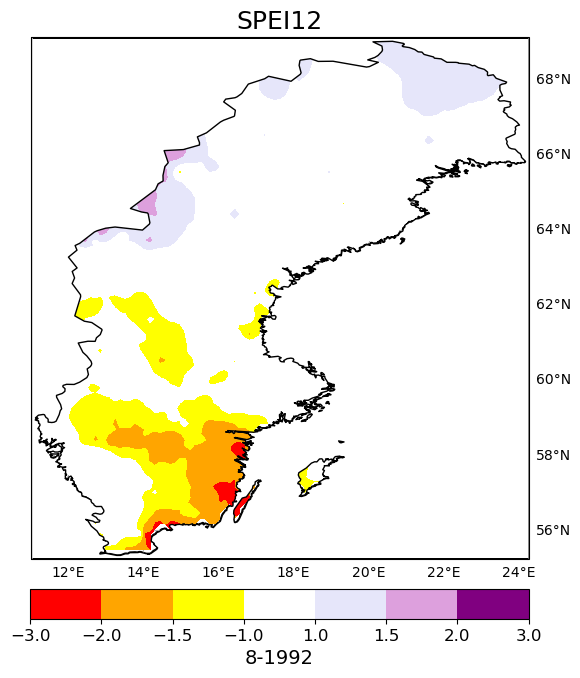

In [27]:
# Specify the month and year of interest
target_month = 8
target_year = 1992
spi_time = spi_ds['time']
delta_time = abs((spi_time.dt.month - target_month) + (spi_time.dt.year - target_year) * 12)
t = delta_time.argmin()
#t = 309
month = spi_ds.time.values[t].astype('datetime64[M]').astype(int) % 12 + 1
year = spi_ds.time.values[t].astype('datetime64[Y]').astype(int) + 1970
#def plot_map(interp_temps, title, label, lower_bound, upper_bound, vcenter, option, cmap_type, save, filename):
plot_map(spi_ds.SPEI.values[t,:], 'SPEI12', str(month)+'-'+str(year), -3, 3, 0, 'contourf', 'SPI_cmap', 'no', 'noname')


In [123]:
def find_droughts(time, spi_point):
    # initialize output arrays
    dry_months = np.zeros_like(spi_point)
    duration = np.zeros_like(spi_point)
    intensity = np.zeros_like(spi_point)
    frequency = np.zeros_like(spi_point)
    starts = np.zeros_like(spi_point)
    # find droughts
    drought_start = -1
    num_droughts = 0
    num_extreme_droughts = 0 # new counter for extreme droughts
    current_year = int(str(time[0].astype('M8[Y]')).split('-')[0])
    for i, (spi, dt) in enumerate(zip(spi_point, time)):
        year = int(str(dt.astype('M8[Y]')).split('-')[0])
        if year > current_year:
            current_year = year
            num_droughts = 0
            num_extreme_droughts = 0 # reset counters at the start of each new year

        #if spi < 0: # old drought definition
        if spi <=-1:
            if drought_start == -1:
                drought_start = i
            dry_months[i] = 1
        else:
            if drought_start != -1:
                drought_end = i - 1
                drought_duration = drought_end - drought_start + 1
                duration[drought_start] = drought_duration
                starts[drought_start] = 1
                drought_intensity = np.sum(spi_point[drought_start:drought_end+1])
                intensity[drought_start] = drought_intensity
                drought_peak = np.min(spi_point[drought_start:drought_end+1])
                if drought_peak<=0: # # count all droughts
                    frequency[drought_start] = num_extreme_droughts + 1 # increment the frequency counter
                    num_extreme_droughts += 1 # increment the counter for extreme droughts only
                num_droughts += 1 # always increment the total drought counter
                drought_start = -1

    # handle last drought if it exists
    if drought_start != -1:
        drought_end = len(spi_point) - 1
        drought_duration = drought_end - drought_start + 1
        duration[drought_start] = drought_duration
        starts[drought_start] = 1
        drought_intensity = np.sum(spi_point[drought_start:drought_end+1])
        intensity[drought_start] = drought_intensity
        drought_peak = np.min(spi_point[drought_start:drought_end+1])
        if drought_peak<=0: # count all droughts
            frequency[drought_start] = num_extreme_droughts + 1 # increment the frequency counter
            num_extreme_droughts += 1 # increment the counter for extreme droughts only

    return duration, intensity, dry_months, frequency, starts

In [126]:
import xarray as xr
import pandas as pd
import numpy as np

# Compute drought intensity, duration and frequency at all points and save results
spi_ds = xr.open_dataset('SPEI12.nc')
lat_grid = np.linspace(55.3376, 69.1763, 100) 
lon_grid = np.linspace(11, 24.113, 100)

# Create empty dataset with desired dimensions and coordinates
ds = xr.Dataset(
    {
        'dr_durs': (['time', 'lat', 'lon'], np.zeros((len(spi_ds.time.values), 100, 100))),
        'dr_ints': (['time', 'lat', 'lon'], np.zeros((len(spi_ds.time.values), 100, 100))),
        'dr_mons': (['time', 'lat', 'lon'], np.zeros((len(spi_ds.time.values), 100, 100))),
        'dr_freq': (['time', 'lat', 'lon'], np.zeros((len(spi_ds.time.values), 100, 100))),
        'dr_star': (['time', 'lat', 'lon'], np.zeros((len(spi_ds.time.values), 100, 100))),
    },
    coords={
        'time': spi_ds.time.values,
        'lat': lat_grid,
        'lon': lon_grid,
    }
)

# Fill in dataset with drought data
for i in range(len(lat_grid)):
    for j in range(len(lon_grid)):
        print(i,j)
        time = spi_ds.sel(lat=lat_grid[i], lon=lon_grid[j])['time'].values
        spi_values = spi_ds.sel(lat=lat_grid[i], lon=lon_grid[j])['SPEI'].values
        duration, intensity, dry_months, frequency, starts = find_droughts(time, spi_values)
        ds['dr_durs'][:,i,j] = duration
        ds['dr_ints'][:,i,j] = intensity
        ds['dr_mons'][:,i,j] = dry_months
        ds['dr_freq'][:,i,j] = frequency
        ds['dr_star'][:,i,j] = starts

# Save dataset as netCDF file
ds.to_netcdf('drought_data_SPEI12.nc')
ds.close()

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
1 50
1 51
1 52
1 53
1 54
1 55
1 56
1 57
1 58
1 59
1 60
1 61
1 62
1 63
1 64
1 65
1 66
1 67
1 68
1 69
1 70
1 71
1 72
1 73
1 74
1 75
1 76
1 77
1 78
1 79
1 80
1 81
1 82
1 83
1 84
1 85
1 86
1 87
1 88
1 89
1 90
1 91
1 92
1 93
1 94
1 95
1 96
1 97
1 98
1 99
2 0
2 1
2 2
2 3
2 4


15 61
15 62
15 63
15 64
15 65
15 66
15 67
15 68
15 69
15 70
15 71
15 72
15 73
15 74
15 75
15 76
15 77
15 78
15 79
15 80
15 81
15 82
15 83
15 84
15 85
15 86
15 87
15 88
15 89
15 90
15 91
15 92
15 93
15 94
15 95
15 96
15 97
15 98
15 99
16 0
16 1
16 2
16 3
16 4
16 5
16 6
16 7
16 8
16 9
16 10
16 11
16 12
16 13
16 14
16 15
16 16
16 17
16 18
16 19
16 20
16 21
16 22
16 23
16 24
16 25
16 26
16 27
16 28
16 29
16 30
16 31
16 32
16 33
16 34
16 35
16 36
16 37
16 38
16 39
16 40
16 41
16 42
16 43
16 44
16 45
16 46
16 47
16 48
16 49
16 50
16 51
16 52
16 53
16 54
16 55
16 56
16 57
16 58
16 59
16 60
16 61
16 62
16 63
16 64
16 65
16 66
16 67
16 68
16 69
16 70
16 71
16 72
16 73
16 74
16 75
16 76
16 77
16 78
16 79
16 80
16 81
16 82
16 83
16 84
16 85
16 86
16 87
16 88
16 89
16 90
16 91
16 92
16 93
16 94
16 95
16 96
16 97
16 98
16 99
17 0
17 1
17 2
17 3
17 4
17 5
17 6
17 7
17 8
17 9
17 10
17 11
17 12
17 13
17 14
17 15
17 16
17 17
17 18
17 19
17 20
17 21
17 22
17 23
17 24
17 25
17 26
17 27
17 28
17 29
17 30


29 50
29 51
29 52
29 53
29 54
29 55
29 56
29 57
29 58
29 59
29 60
29 61
29 62
29 63
29 64
29 65
29 66
29 67
29 68
29 69
29 70
29 71
29 72
29 73
29 74
29 75
29 76
29 77
29 78
29 79
29 80
29 81
29 82
29 83
29 84
29 85
29 86
29 87
29 88
29 89
29 90
29 91
29 92
29 93
29 94
29 95
29 96
29 97
29 98
29 99
30 0
30 1
30 2
30 3
30 4
30 5
30 6
30 7
30 8
30 9
30 10
30 11
30 12
30 13
30 14
30 15
30 16
30 17
30 18
30 19
30 20
30 21
30 22
30 23
30 24
30 25
30 26
30 27
30 28
30 29
30 30
30 31
30 32
30 33
30 34
30 35
30 36
30 37
30 38
30 39
30 40
30 41
30 42
30 43
30 44
30 45
30 46
30 47
30 48
30 49
30 50
30 51
30 52
30 53
30 54
30 55
30 56
30 57
30 58
30 59
30 60
30 61
30 62
30 63
30 64
30 65
30 66
30 67
30 68
30 69
30 70
30 71
30 72
30 73
30 74
30 75
30 76
30 77
30 78
30 79
30 80
30 81
30 82
30 83
30 84
30 85
30 86
30 87
30 88
30 89
30 90
30 91
30 92
30 93
30 94
30 95
30 96
30 97
30 98
30 99
31 0
31 1
31 2
31 3
31 4
31 5
31 6
31 7
31 8
31 9
31 10
31 11
31 12
31 13
31 14
31 15
31 16
31 17
31 18
31 19


43 43
43 44
43 45
43 46
43 47
43 48
43 49
43 50
43 51
43 52
43 53
43 54
43 55
43 56
43 57
43 58
43 59
43 60
43 61
43 62
43 63
43 64
43 65
43 66
43 67
43 68
43 69
43 70
43 71
43 72
43 73
43 74
43 75
43 76
43 77
43 78
43 79
43 80
43 81
43 82
43 83
43 84
43 85
43 86
43 87
43 88
43 89
43 90
43 91
43 92
43 93
43 94
43 95
43 96
43 97
43 98
43 99
44 0
44 1
44 2
44 3
44 4
44 5
44 6
44 7
44 8
44 9
44 10
44 11
44 12
44 13
44 14
44 15
44 16
44 17
44 18
44 19
44 20
44 21
44 22
44 23
44 24
44 25
44 26
44 27
44 28
44 29
44 30
44 31
44 32
44 33
44 34
44 35
44 36
44 37
44 38
44 39
44 40
44 41
44 42
44 43
44 44
44 45
44 46
44 47
44 48
44 49
44 50
44 51
44 52
44 53
44 54
44 55
44 56
44 57
44 58
44 59
44 60
44 61
44 62
44 63
44 64
44 65
44 66
44 67
44 68
44 69
44 70
44 71
44 72
44 73
44 74
44 75
44 76
44 77
44 78
44 79
44 80
44 81
44 82
44 83
44 84
44 85
44 86
44 87
44 88
44 89
44 90
44 91
44 92
44 93
44 94
44 95
44 96
44 97
44 98
44 99
45 0
45 1
45 2
45 3
45 4
45 5
45 6
45 7
45 8
45 9
45 10
45 11
45 12


57 35
57 36
57 37
57 38
57 39
57 40
57 41
57 42
57 43
57 44
57 45
57 46
57 47
57 48
57 49
57 50
57 51
57 52
57 53
57 54
57 55
57 56
57 57
57 58
57 59
57 60
57 61
57 62
57 63
57 64
57 65
57 66
57 67
57 68
57 69
57 70
57 71
57 72
57 73
57 74
57 75
57 76
57 77
57 78
57 79
57 80
57 81
57 82
57 83
57 84
57 85
57 86
57 87
57 88
57 89
57 90
57 91
57 92
57 93
57 94
57 95
57 96
57 97
57 98
57 99
58 0
58 1
58 2
58 3
58 4
58 5
58 6
58 7
58 8
58 9
58 10
58 11
58 12
58 13
58 14
58 15
58 16
58 17
58 18
58 19
58 20
58 21
58 22
58 23
58 24
58 25
58 26
58 27
58 28
58 29
58 30
58 31
58 32
58 33
58 34
58 35
58 36
58 37
58 38
58 39
58 40
58 41
58 42
58 43
58 44
58 45
58 46
58 47
58 48
58 49
58 50
58 51
58 52
58 53
58 54
58 55
58 56
58 57
58 58
58 59
58 60
58 61
58 62
58 63
58 64
58 65
58 66
58 67
58 68
58 69
58 70
58 71
58 72
58 73
58 74
58 75
58 76
58 77
58 78
58 79
58 80
58 81
58 82
58 83
58 84
58 85
58 86
58 87
58 88
58 89
58 90
58 91
58 92
58 93
58 94
58 95
58 96
58 97
58 98
58 99
59 0
59 1
59 2
59 3


71 27
71 28
71 29
71 30
71 31
71 32
71 33
71 34
71 35
71 36
71 37
71 38
71 39
71 40
71 41
71 42
71 43
71 44
71 45
71 46
71 47
71 48
71 49
71 50
71 51
71 52
71 53
71 54
71 55
71 56
71 57
71 58
71 59
71 60
71 61
71 62
71 63
71 64
71 65
71 66
71 67
71 68
71 69
71 70
71 71
71 72
71 73
71 74
71 75
71 76
71 77
71 78
71 79
71 80
71 81
71 82
71 83
71 84
71 85
71 86
71 87
71 88
71 89
71 90
71 91
71 92
71 93
71 94
71 95
71 96
71 97
71 98
71 99
72 0
72 1
72 2
72 3
72 4
72 5
72 6
72 7
72 8
72 9
72 10
72 11
72 12
72 13
72 14
72 15
72 16
72 17
72 18
72 19
72 20
72 21
72 22
72 23
72 24
72 25
72 26
72 27
72 28
72 29
72 30
72 31
72 32
72 33
72 34
72 35
72 36
72 37
72 38
72 39
72 40
72 41
72 42
72 43
72 44
72 45
72 46
72 47
72 48
72 49
72 50
72 51
72 52
72 53
72 54
72 55
72 56
72 57
72 58
72 59
72 60
72 61
72 62
72 63
72 64
72 65
72 66
72 67
72 68
72 69
72 70
72 71
72 72
72 73
72 74
72 75
72 76
72 77
72 78
72 79
72 80
72 81
72 82
72 83
72 84
72 85
72 86
72 87
72 88
72 89
72 90
72 91
72 92
72 93
72 94
72

85 19
85 20
85 21
85 22
85 23
85 24
85 25
85 26
85 27
85 28
85 29
85 30
85 31
85 32
85 33
85 34
85 35
85 36
85 37
85 38
85 39
85 40
85 41
85 42
85 43
85 44
85 45
85 46
85 47
85 48
85 49
85 50
85 51
85 52
85 53
85 54
85 55
85 56
85 57
85 58
85 59
85 60
85 61
85 62
85 63
85 64
85 65
85 66
85 67
85 68
85 69
85 70
85 71
85 72
85 73
85 74
85 75
85 76
85 77
85 78
85 79
85 80
85 81
85 82
85 83
85 84
85 85
85 86
85 87
85 88
85 89
85 90
85 91
85 92
85 93
85 94
85 95
85 96
85 97
85 98
85 99
86 0
86 1
86 2
86 3
86 4
86 5
86 6
86 7
86 8
86 9
86 10
86 11
86 12
86 13
86 14
86 15
86 16
86 17
86 18
86 19
86 20
86 21
86 22
86 23
86 24
86 25
86 26
86 27
86 28
86 29
86 30
86 31
86 32
86 33
86 34
86 35
86 36
86 37
86 38
86 39
86 40
86 41
86 42
86 43
86 44
86 45
86 46
86 47
86 48
86 49
86 50
86 51
86 52
86 53
86 54
86 55
86 56
86 57
86 58
86 59
86 60
86 61
86 62
86 63
86 64
86 65
86 66
86 67
86 68
86 69
86 70
86 71
86 72
86 73
86 74
86 75
86 76
86 77
86 78
86 79
86 80
86 81
86 82
86 83
86 84
86 85
86 86
86

99 10
99 11
99 12
99 13
99 14
99 15
99 16
99 17
99 18
99 19
99 20
99 21
99 22
99 23
99 24
99 25
99 26
99 27
99 28
99 29
99 30
99 31
99 32
99 33
99 34
99 35
99 36
99 37
99 38
99 39
99 40
99 41
99 42
99 43
99 44
99 45
99 46
99 47
99 48
99 49
99 50
99 51
99 52
99 53
99 54
99 55
99 56
99 57
99 58
99 59
99 60
99 61
99 62
99 63
99 64
99 65
99 66
99 67
99 68
99 69
99 70
99 71
99 72
99 73
99 74
99 75
99 76
99 77
99 78
99 79
99 80
99 81
99 82
99 83
99 84
99 85
99 86
99 87
99 88
99 89
99 90
99 91
99 92
99 93
99 94
99 95
99 96
99 97
99 98
99 99


PermissionError: [Errno 13] Permission denied: b'C:\\Users\\MarlonVieiraPassos\\OneDrive - SEI\\Documents\\HydroHazards\\Codes\\SMHI API\\Droughts\\drought_data_SPEI12.nc'

In [131]:
import xarray as xr
dr_ds = xr.open_dataset('drought_data_SPEI12.nc')
dr_ds = dr_ds.sel(time=slice('1923-01-01', None)) # Use for SPEI

In [200]:
import numpy as np
#np.nanmax(dr_ds.dr_durs.values)
#max_dur = np.nanmax(dr_ds.dr_durs.values, axis=0) # maximum drought durations
#max_int = np.nanmin(dr_ds.dr_ints.values, axis=0) # strongest drought intensities
#tot_num = dr_ds.dr_nums.values
# define a function to calculate percentiles along the time dimension
def calc_percentiles(data):
    return np.nanpercentile(data, [10, 50, 90], axis=0)
# convert xarray data to a numpy array
#dr_peak_np = spi_ds.SPEI.values
#dr_peak_np[dr_peak_np==0]=np.nan
#dr_durs_np = dr_ds.dr_durs.values
dr_durs_np = dr_ds_decade.dr_durs.values # changed to total duration of droughts per decade
#dr_durs_np[dr_durs_np==0]=np.nan
dr_ints_np = dr_ds_decade.dr_ints.values
#dr_ints_np[dr_ints_np==0]=np.nan
#dr_freq_np = dr_ds_yearly.dr_freq.values # number of droughts per year
#dr_freq_np = dr_ds_yearly.dr_mons.values # number of dry months per year
#dr_freq_np = dr_ds_decade.dr_mons.values # number of dry months per decade
#dr_freq_np = dr_ds_yearly.dr_star.values # number of droughts per year
#dr_freq_np = dr_ds_decade2.dr_freq.values # number of droughts per decade
dr_freq_np = dr_ds_decade.dr_star.values # number of droughts per decade
#dr_freq_np[dr_freq_np==0]=np.nan
#dr_freq_np = np.nan_to_num(dr_freq_np, nan=0)
# calculate percentiles using the function and numpy array
#peak_perc_np = calc_percentiles(dr_peak_np)
dur_perc_np = calc_percentiles(dr_durs_np)
int_perc_np = calc_percentiles(dr_ints_np)
freq_perc_np = calc_percentiles(dr_freq_np)



C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\ca

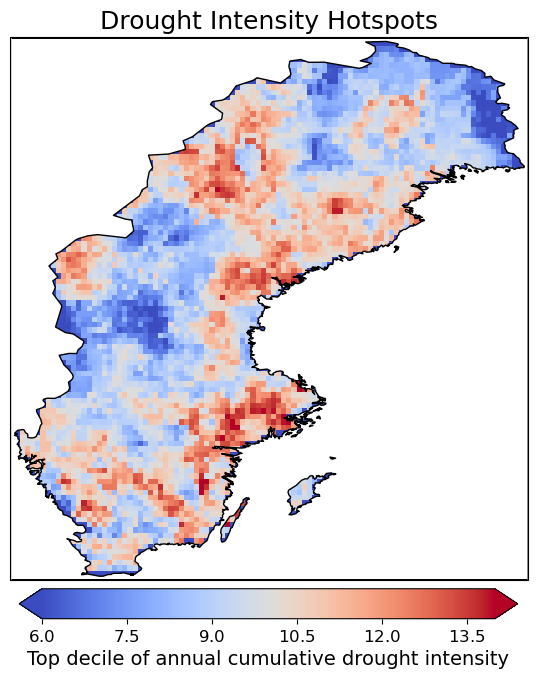

In [185]:

# Plot strongest intensity
plt.rcdefaults()
#plot_data=np.nanmin(dr_ints_np, axis=0)
plot_data=int_perc_np[0]*(-1) # absolute values
lb=int(np.percentile(plot_data[plot_data>0], 0.01))
ub=int(np.percentile(plot_data[plot_data>0], 99.99))
vcenter=int(np.percentile(plot_data[plot_data>0], 50))
ub=14
lb=6
#vcenter=-300
plot_map(plot_data, 'Drought Intensity Hotspots', 'Top decile of annual cumulative drought intensity', lb, ub, vcenter, 'imshow', 'normal','no','no')

In [182]:
ub

1

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\ca

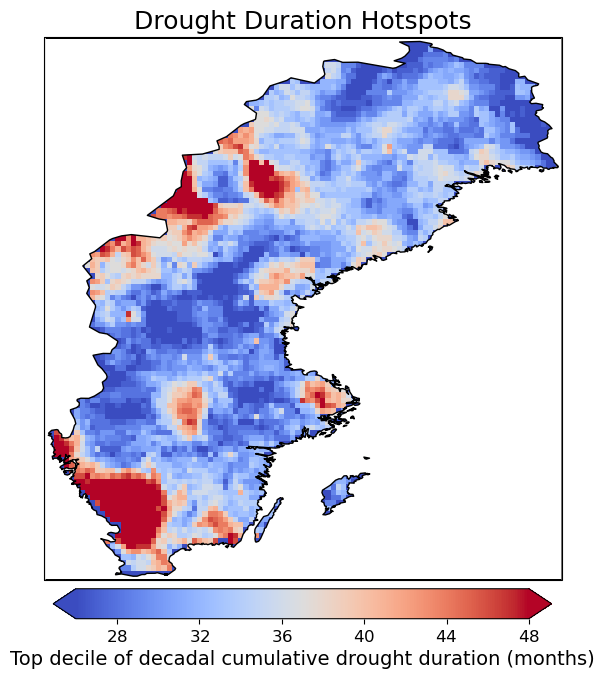

In [201]:
# Plot longest duration
#plot_data=np.nanmax(dr_durs_np, axis=0)/12
plot_data=dur_perc_np[2]
lb=int(np.percentile(plot_data[plot_data>0], 5))
ub=int(np.percentile(plot_data[plot_data>0], 95))
#vcenter=int(np.percentile(plot_data[plot_data>0], 50))
#ub=9
#lb=4
#vcenter=5
plot_map(plot_data, 'Drought Duration Hotspots', 'Top decile of decadal cumulative drought duration (months)', lb, ub, vcenter, 'imshow', 'normal','no','no')

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\ca

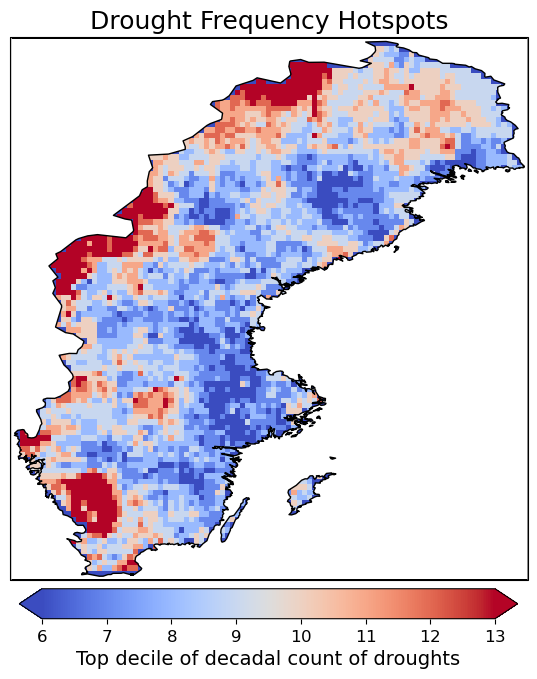

In [199]:
# Reset Matplotlib settings to defaults
#plt.rcParams.update(plt.rcParamsDefault)
plot_data=freq_perc_np[2] # 90th percentile of droughts per decade or year depending on previous cell
lb=int(np.percentile(plot_data[plot_data>0], 5))
ub=int(np.percentile(plot_data[plot_data>0], 95))
vcenter=int(np.percentile(plot_data[plot_data>0], 50))
#ub=10
#lb=4
#vcenter=2
#plot_map(plot_data, '90th Percentile Dry Month Count per Decade', lb, ub, vcenter, 'imshow', 'normal','no','no')
plot_map(plot_data, 'Drought Frequency Hotspots', 'Top decile of decadal count of droughts', lb, ub, vcenter, 'imshow', 'normal','no','no')
#plot_map(plot_data, 'Drought Frequency (Dry Months per Decade)', '90th Percentile Values', lb, ub, vcenter, 'imshow', 'normal','no','no')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
ds=dr_ds_yearly
# Create a function to plot scatter plots
def plot_scatter(x, y, xlabel, ylabel, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=x, y=y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

# Create the scatter plots
plot_scatter(ds['dr_durs'].values.flatten(), ds['dr_freq'].values.flatten(), 
             'Duration', 'Frequency', 'Duration vs Frequency')
plot_scatter(ds['dr_ints'].values.flatten(), ds['dr_freq'].values.flatten(), 
             'Intensity', 'Frequency', 'Intensity vs Frequency')
plot_scatter(ds['dr_ints'].values.flatten(), ds['dr_durs'].values.flatten(), 
             'Intensity', 'Duration', 'Intensity vs Duration')

In [ ]:
import seaborn as sns
from scipy.stats import pearsonr
def plot_reg(df, colx, coly, lbx, lby):
    df=df.dropna()
    # Calculate correlation coefficient
    corr, _ = pearsonr(df[colx], df[coly])
    # Create scatter plot with regression line and correlation coefficient
    g=sns.jointplot(x=colx, y=coly, data=df, kind='reg',  line_kws={"color":"red"})
    # Add text box with correlation coefficient
    g.ax_joint.text(0.1, 0.9, f"R = {corr:.2f}", fontsize=12,
                transform=g.ax_joint.transAxes,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
    # Set custom x and y axis labels
    g.set_axis_labels(lbx, lby)
    # Display the plot
    plt.show()    

In [ ]:
ssi_ds = xr.open_dataset('SSI12.nc')
ssi_df=ssi_ds.to_dataframe()

In [88]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, linregress

def calculate_trends(data_array, alpha=0.05):
    timesteps, n_lat, n_lon = data_array.shape

    x = np.arange(timesteps)
    rate_of_change = np.empty((n_lat, n_lon))

    for i in range(n_lat):
        for j in range(n_lon):
            y = data_array[:, i, j]
            mask = ~np.isnan(y)
            if mask.sum() > 1:
                slope, intercept, r_value, p_value, std_err = linregress(x[mask], y[mask])
                if p_value <= alpha:
                    rate_of_change[i, j] = slope
                else:
                    rate_of_change[i, j] = np.nan
            else:
                rate_of_change[i, j] = np.nan

    return rate_of_change

In [99]:
dr_ds = xr.open_dataset('drought_data_SPEI12.nc')
dr_ds = dr_ds.sel(time=slice('1923-01-01', None)) # Use for SPEI
dr_ds_yearly =dr_ds.resample(time='1Y').sum('time')

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\ca

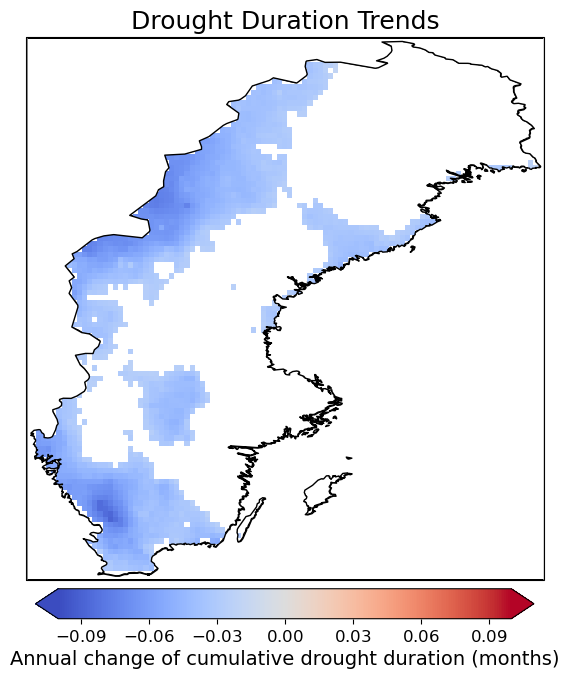

In [191]:
dr_dur_rate=calculate_trends(dr_durs_np) # Total duration per decade
plot_map(dr_dur_rate, 'Drought Duration Trends', 'Annual change of cumulative drought duration (months)', -0.1, 0.1, 0, 'imshow','coolwarm', 'no', 'no')

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\ca

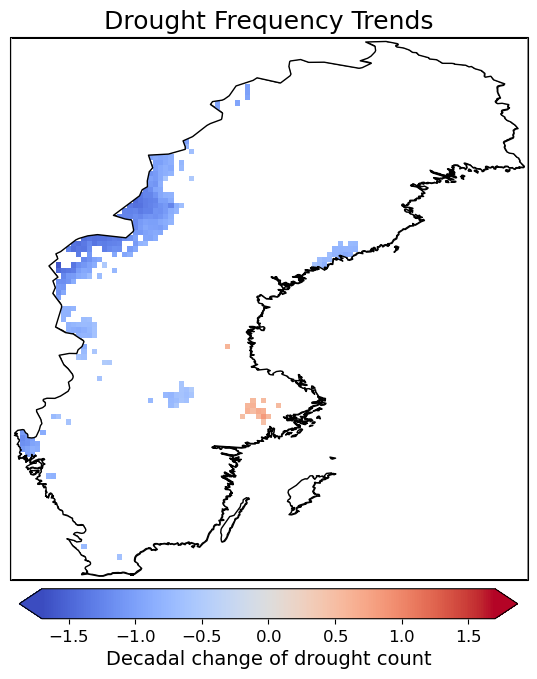

In [192]:
#dr_freq_corr=calculate_trends(dr_ds.dr_freq) 
dr_freq_rate=calculate_trends(dr_freq_np)
plot_map(dr_freq_rate, 'Drought Frequency Trends', 'Decadal change of drought count', -1.7, 1.7, 0, 'imshow','coolwarm', 'no', 'no')

C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
C:\Users\MarlonVieiraPassos\anaconda3\lib\site-packages\ca

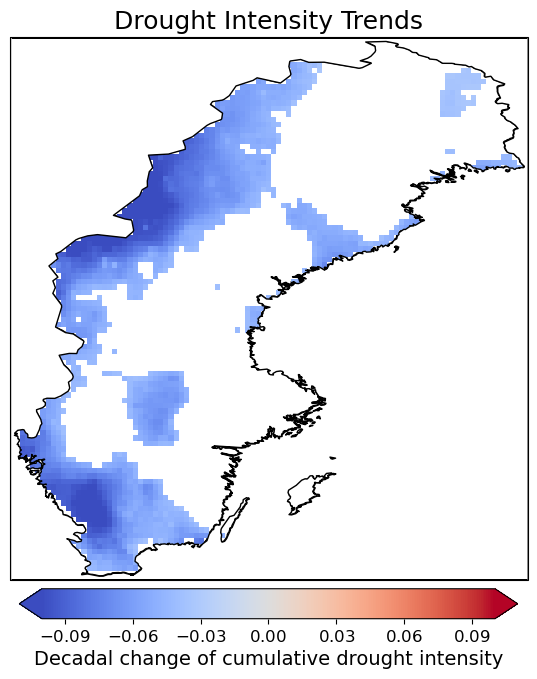

In [193]:
#%%capture --no-display
dr_int_rate=calculate_trends(dr_ints_np*(-1)) # Total drought intensity per year, -1 for positive intensities
plot_map(dr_int_rate, 'Drought Intensity Trends', 'Decadal change of cumulative drought intensity', -0.1, 0.1, 0, 'imshow','coolwarm', 'no', 'no')
#plot_map(dr_int_corr, 'Drought Intensity Trends (R-value)', -0.5, 0.5, 0, 'imshow', 'normal','no','no')